## Demand Forecasting: Regression Analysis and Model Training

### 1. Problem Statement
- The energy industry is undergoing a transformative journey, marked by rapid modernization and technological advancements. Infrastructure upgrades, integration of intermittent renewable energy sources, and evolving consumer demands are reshaping the sector. However, this progress comes with its challenges. Supply, demand, and prices are increasingly volatile, rendering the future less predictable. Moreover, the industry's traditional business models are being fundamentally challenged. In this competitive and dynamic landscape, accurate decision-making is pivotal. The industry relies heavily on probabilistic forecasts to navigate this uncertain future, making innovative and precise forecasting methods essential that aids stakeholders in making strategic decisions amidst the shifting energy landscape. 

In [3]:
import warnings
warnings.filterwarnings("ignore")

### 2. Data Ingestion

#### [Zenml-MLfow pipeline for Data Ingestion](../steps/demand_forecasting/1_data_ingestion.py)

#### 2.1 Import Data and Required Packages
- Importing Pandas, Numpy, Matplotlib, Seaborn, Scikit-learn 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import joblib



#### 2.2 Import the CSV Data as Pandas DataFrame
- Importing both Demand and Weather Data of Demand Forecasting and merging them

In [5]:
df_demand = pd.read_csv('../dataset/Demand Forecasting/Demand Forecasting Demand Data upto Feb 21.csv', sep=',')
df_weather = pd.read_csv('../dataset/Demand Forecasting/Demand Forecasting Weather Data upto Feb 28.csv', sep=',')
df_merged=pd.merge(left=df_demand,right=df_weather, on='datetime')


### 3. Data Preprocessing and Visualizations

#### 3.1 Show Top 5 Records
 - Showing top 5 and last 5 records


In [6]:
df_merged.head()

,datetime,Demand (MW),Name,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,1/1/2020 0:00,445.8,Pokhara,38.0,34.4,29.0,69.76,0.0,0,NaN,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
1,1/1/2020 1:00,424.5,Pokhara,38.0,34.4,29.9,72.37,0.0,0,NaN,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2,1/1/2020 2:00,423.5,Pokhara,38.0,35.7,30.8,75.06,0.0,0,NaN,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
3,1/1/2020 3:00,418.8,Pokhara,37.1,33.4,29.9,74.97,0.0,0,NaN,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
4,1/1/2020 4:00,414.8,Pokhara,35.1,32.3,29.0,78.41,0.0,0,NaN,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN


In [7]:
df_merged.tail()

,datetime,Demand (MW),Name,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
27547,2/21/2023 19:00,498.7,Pokhara,50.0,49.4,29.0,44.19,0.0,0,NaN,...,9.9,0.0,0,10.0,Partially cloudy,NaN,NaN,NaN,NaN,NaN
27548,2/21/2023 20:00,498.8,Pokhara,50.0,49.4,28.1,42.59,0.0,0,NaN,...,9.9,0.0,0,10.0,Partially cloudy,NaN,NaN,NaN,NaN,NaN
27549,2/21/2023 21:00,506.4,Pokhara,53.1,53.1,26.1,34.92,0.0,0,NaN,...,9.9,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN
27550,2/21/2023 22:00,478.8,Pokhara,53.1,53.1,28.1,38.02,0.0,0,NaN,...,9.9,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN
27551,2/21/2023 23:00,457.7,Pokhara,53.1,53.1,30.8,42.44,0.0,0,NaN,...,9.9,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN


#### 3.2 Checking if Unamed columns have any data
- Checking the data in unnamed columns and removing all the empty columns

In [8]:
for i in range(21, 26):
    column_name = f'Unnamed: {i}'
    count_non_null = df_merged[column_name].notna().sum()
    print(f"Non-null values in {column_name}: {count_non_null}")

Non-null values in Unnamed: 21: 0
Non-null values in Unnamed: 22: 0
Non-null values in Unnamed: 23: 0
Non-null values in Unnamed: 24: 0
Non-null values in Unnamed: 25: 1


In [9]:
columns_to_drop = ['Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']
df_merged.drop(columns_to_drop, inplace=True, axis=1)

#### 3.3 Performing Datachecks
- Checking for null values

In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          27552 non-null  object 
 1   Demand (MW)       27552 non-null  float64
 2   Name              27552 non-null  object 
 3   Temperature       27552 non-null  float64
 4   feelslike         27552 non-null  float64
 5   dewpoint          27552 non-null  float64
 6   humidity          27552 non-null  float64
 7   precipitation     27552 non-null  float64
 8   precipprob        27552 non-null  int64  
 9   preciptype        2745 non-null   object 
 10  snow              27534 non-null  float64
 11  snowdepth         27534 non-null  float64
 12  windgust          12055 non-null  float64
 13  windspeed         27552 non-null  float64
 14  winddirection     27552 non-null  float64
 15  sealevelpressure  27534 non-null  float64
 16  cloudcover        27552 non-null  float6

#### 3.4 Filling most appropriate values for severerisk 
- Filling severerisk with 0 on nan values for more appropraite correlation analysis

In [11]:
df_merged['severerisk'].fillna(0, inplace=True)

#### 3.5 Dropping redundant data
- Dropping preciptype and precipprob as precipitation has more accurate and non-null data, similarly dropping windgust and keeping windspeed

In [12]:
df_merged.drop(["precipprob", "preciptype" ], inplace=True, axis=1)
df_merged.drop(['windgust'], inplace=True, axis=1)

In [13]:
df_merged

,datetime,Demand (MW),Name,Temperature,feelslike,dewpoint,humidity,precipitation,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
0,1/1/2020 0:00,445.8,Pokhara,38.0,34.4,29.0,69.76,0.0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,0.0,Overcast
1,1/1/2020 1:00,424.5,Pokhara,38.0,34.4,29.9,72.37,0.0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,0.0,Overcast
2,1/1/2020 2:00,423.5,Pokhara,38.0,35.7,30.8,75.06,0.0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,0.0,Overcast
3,1/1/2020 3:00,418.8,Pokhara,37.1,33.4,29.9,74.97,0.0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,0.0,Partially cloudy
4,1/1/2020 4:00,414.8,Pokhara,35.1,32.3,29.0,78.41,0.0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,0.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27547,2/21/2023 19:00,498.7,Pokhara,50.0,49.4,29.0,44.19,0.0,0.0,0.0,3.4,100.0,1009.1,50.0,9.9,0.0,0,10.0,Partially cloudy
27548,2/21/2023 20:00,498.8,Pokhara,50.0,49.4,28.1,42.59,0.0,0.0,0.0,3.4,110.0,1008.1,88.9,9.9,0.0,0,10.0,Partially cloudy
27549,2/21/2023 21:00,506.4,Pokhara,53.1,53.1,26.1,34.92,0.0,0.0,0.0,5.8,130.0,1007.3,100.0,9.9,0.0,0,10.0,Overcast
27550,2/21/2023 22:00,478.8,Pokhara,53.1,53.1,28.1,38.02,0.0,0.0,0.0,5.8,110.0,1006.2,100.0,9.9,0.0,0,10.0,Overcast


#### 3.6 Interpolation of data
- Using .interpolate() method to add most appropriate datas in place of NaN values

In [14]:
for column in df_merged.columns[3:17]:
    df_merged[column] = df_merged[column].interpolate(method='linear', limit_direction='forward', axis=0)

#### 3.7 Histogram & KDE
 - It is evident that the distribution of the 'Demand (MW)' column in the dataset closely aligns with a log-normal distribution.

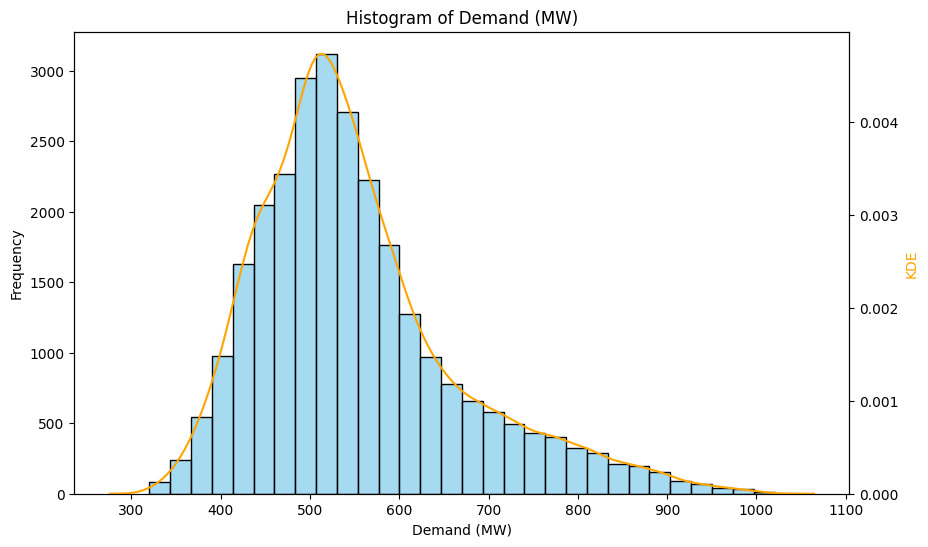

In [15]:
df_merged['datetime'] = pd.to_datetime(df_merged['datetime'])

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df_merged['Demand (MW)'], kde=False, bins=30, color='skyblue', ax=ax)
ax.set_title(f'Histogram of Demand (MW)')
ax.set_xlabel('Demand (MW)')
ax.set_ylabel('Frequency')

ax2 = ax.twinx()
sns.kdeplot(df_merged['Demand (MW)'], color='orange', ax=ax2)
ax2.set_ylabel('KDE', color='orange')

plt.show()

#### 3.8 Analyzing Correlation 
- Analyzing Correlation between Demand(MW) and other paramaters

In [16]:
for column in df_merged.columns[3:18]:
    print(f"Correlation of price with {column}: {df_merged['Demand (MW)'].corr(df_merged[column])}")

Correlation of price with Temperature: 0.45233960384840355
Correlation of price with feelslike: 0.441472933404926
Correlation of price with dewpoint: 0.3626129965433106
Correlation of price with humidity: -0.19572462989123404
Correlation of price with precipitation: -0.01703203825114375
Correlation of price with snow: 0.015329744060287654
Correlation of price with snowdepth: 0.05360803598398459
Correlation of price with windspeed: 0.06389316675486967
Correlation of price with winddirection: 0.05303417125254191
Correlation of price with sealevelpressure: -0.029717039764268365
Correlation of price with cloudcover: -0.06553044175434337
Correlation of price with visibility: 0.08506004019113429
Correlation of price with solarradiation: 0.37546701739356325
Correlation of price with uvindex: 0.37277231672656097
Correlation of price with severerisk: 0.23056008626748425


- Plotting a heatmap of corrlation

<Axes: >

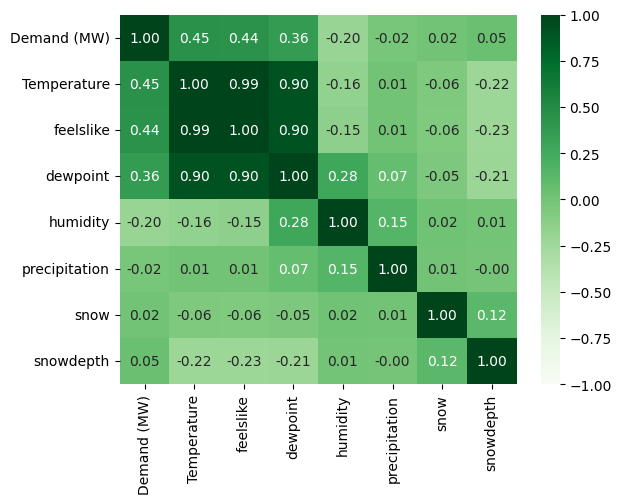

In [17]:
selected_columns = df_merged.columns[[1] + list(range(3, 10))]
correlation_matrix =df_merged[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", vmin=-1, vmax=1)

#### 3.9 Regrestion Plot of highly correlated datas
- Demand(MW) has high correlation with temperature and dewpoint whose regression plot are as follows.

<Axes: xlabel='Temperature', ylabel='Demand (MW)'>

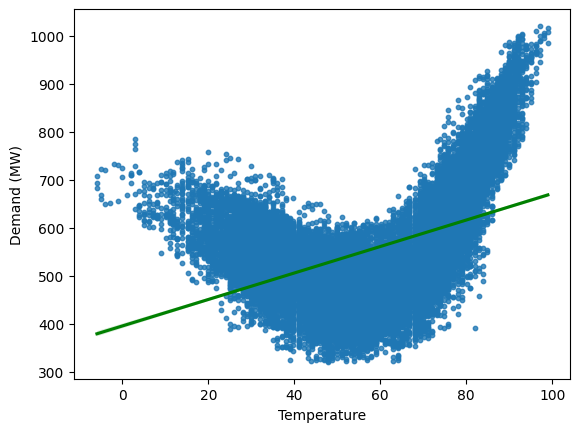

In [18]:
sns.regplot(x='Temperature', y='Demand (MW)', data=df_merged, scatter_kws={'s': 10}, line_kws={'color': 'green'})

<Axes: xlabel='dewpoint', ylabel='Demand (MW)'>

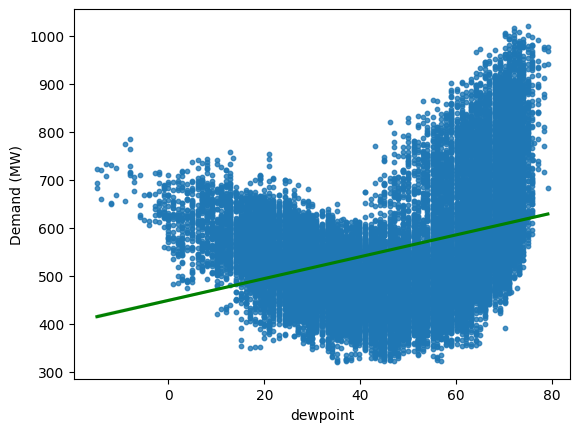

In [19]:
sns.regplot(x='dewpoint', y='Demand (MW)', data=df_merged, scatter_kws={'s': 10}, line_kws={'color': 'green'})

- Grouping data by month within each date and plotting a scatter plot between Temperature, dewpoint and Demand (MW)

In [20]:
tempdf = df_merged
tempdf['datetime'] = pd.to_datetime(df_merged['datetime'])

numeric_columns = df_merged.select_dtypes(include=['number']).columns

# Grouping by date and then by month within each date, and calculating the mean for numeric columns
monthlydf = tempdf.groupby(tempdf['datetime'].dt.to_period("M"))[numeric_columns].mean().reset_index()

<Axes: xlabel='Temperature', ylabel='Demand (MW)'>

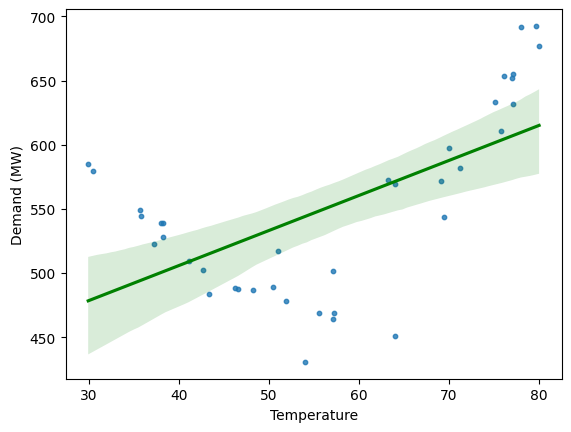

In [21]:

sns.regplot(x='Temperature', y='Demand (MW)', data=monthlydf, scatter_kws={'s': 10}, line_kws={'color': 'green'})

<Axes: xlabel='dewpoint', ylabel='Demand (MW)'>

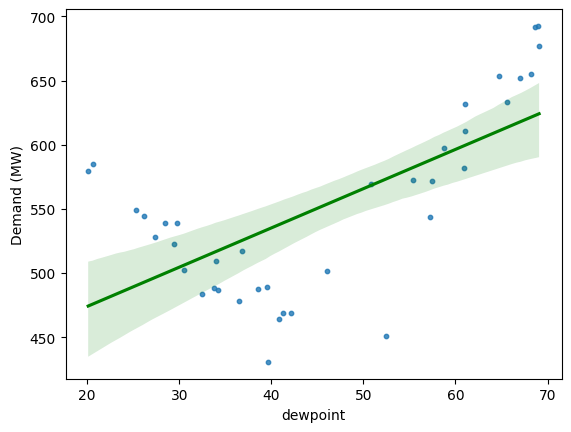

In [22]:
sns.regplot(x='dewpoint', y='Demand (MW)', data=monthlydf, scatter_kws={'s': 10}, line_kws={'color': 'green'})

#### 3.10 Dropping less significant data
Dropping less significant data after correlation analysis, i.e very low correlation as well as redundant data (i.e solarradiation and uv index where both have almost 1 correlation , here data with higher correlation is kept)


In [23]:
print(df_merged["solarradiation"].corr(df_merged["uvindex"]))
print(df_merged["Temperature"].corr(df_merged["feelslike"]))

0.9963920843433209
0.9941671111931236


In [24]:
df_merged.drop(['feelslike','uvindex', 'precipitation', 'sealevelpressure', 'snow', 'snowdepth', 'windspeed', 'winddirection'], inplace=True, axis=1)

#### 3.11 Visualization of categorical data
- Plotting conditions vs Demand(MW)

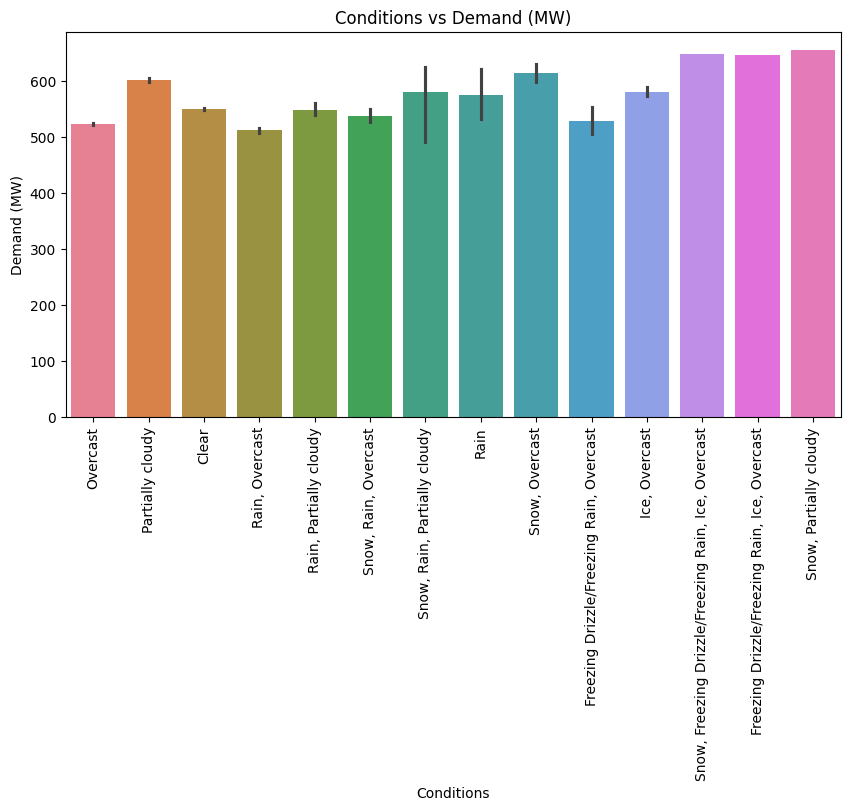

In [25]:
plt.figure(figsize=(10, 5))
sns.barplot(x='conditions', y='Demand (MW)',hue='conditions', data=df_merged)

plt.title('Conditions vs Demand (MW)')
plt.xlabel('Conditions')
plt.ylabel('Demand (MW)')
plt.xticks(rotation=90)

plt.show()

### 4. Feature Engineering

#### 4.1 Handling Categorical Data
Using pandas get dummies to handle categorical variables like 
condition creating new columns consisting of 0s and 1s for each columns 

In [26]:
dummies = pd.get_dummies(df_merged['conditions'], prefix='overcast')
df_final = pd.concat([df_merged, dummies], axis=1)

In [27]:
df_merged.iloc[:,3:10]

,Temperature,dewpoint,humidity,cloudcover,visibility,solarradiation,severerisk
0,38.0,29.0,69.76,100.0,9.9,0.0,0.0
1,38.0,29.9,72.37,100.0,9.9,0.0,0.0
2,38.0,30.8,75.06,100.0,9.9,0.0,0.0
3,37.1,29.9,74.97,88.9,9.9,0.0,0.0
4,35.1,29.0,78.41,0.0,9.9,0.0,0.0
...,...,...,...,...,...,...,...
27547,50.0,29.0,44.19,50.0,9.9,0.0,10.0
27548,50.0,28.1,42.59,88.9,9.9,0.0,10.0
27549,53.1,26.1,34.92,100.0,9.9,0.0,10.0
27550,53.1,28.1,38.02,100.0,9.9,0.0,10.0


#### 4.2 Normalization
- Normalize continuous values and avoid vanishing gradient problems to finalize our data before model training.

In [28]:

scaler = MinMaxScaler()
X = scaler.fit_transform(df_merged.iloc[:,3:10])

In [29]:
df_merged.iloc[:,1]

0        445.8
1        424.5
2        423.5
3        418.8
4        414.8
         ...  
27547    498.7
27548    498.8
27549    506.4
27550    478.8
27551    457.7
Name: Demand (MW), Length: 27552, dtype: float64

In [30]:
scaler = MinMaxScaler()
y = scaler.fit_transform(df_merged.iloc[:,1].values.reshape(-1,1))

#### 4.3 Train Validation Test Split
- Splitting the data into different splits

In [31]:
def train_test_split(X, y, train_size=0.8):
    X_train = X[:int(train_size * len(X))]
    X_test = X[int(train_size * len(X)):]
    y_train = y[:int(train_size * len(y))]
    y_test = y[int(train_size * len(y)):]
    return X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [33]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [34]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

In [37]:
def get_parameter_grid_for_model(model_name):
    if model_name == "Lasso":
        return {'alpha': [0.1, 1.0, 10.0]}

    elif model_name == "Ridge":
        return {'alpha': [0.1, 1.0, 10.0]}

    elif model_name == "K-Neighbors Regressor":
        return {'n_neighbors': [3, 5, 7]}

    elif model_name == "Decision Tree":
        return {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}

    elif model_name == "Random Forest Regressor":
        return {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}

    elif model_name == "XGBRegressor":
        return {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

    elif model_name == "CatBoosting Regressor":
        return {'iterations': [50, 100, 200], 'depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}

    elif model_name == "AdaBoost Regressor":
        return {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}

    else:
        raise ValueError(f"Hyperparameter grid not defined for {model_name}")


In [38]:


models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for model_name, model in models.items():
    param_grid = get_parameter_grid_for_model(model_name)

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(model_name)
    print('Best hyperparameters:', grid_search.best_params_)
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('=' * 35)
    print('\n')

    model_list.append(model_name)


Lasso
Best hyperparameters: {'alpha': 0.1}
Model performance for Training set
- Root Mean Squared Error: 0.1636
- Mean Absolute Error: 0.1246
- R2 Score: 0.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1629
- Mean Absolute Error: 0.1237
- R2 Score: -0.0007


Ridge
Best hyperparameters: {'alpha': 1.0}
Model performance for Training set
- Root Mean Squared Error: 0.1397
- Mean Absolute Error: 0.1119
- R2 Score: 0.2705
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1270
- Mean Absolute Error: 0.1026
- R2 Score: 0.3922


K-Neighbors Regressor
Best hyperparameters: {'n_neighbors': 7}
Model performance for Training set
- Root Mean Squared Error: 0.0730
- Mean Absolute Error: 0.0577
- R2 Score: 0.8009
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0922
- Mean Absolute Error: 0.0725
- R2 Score: 0.6794


Decision Tree
Best hyperparameters: {'max_d

In [39]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)

In [40]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
joblib.dump(xgb_model, '../model/demand_forecasting.pkl')

['../model/demand_forecasting.pkl']

In [43]:
xgb_pred = xgb_model.predict(X_test)

In [47]:
print("mean squared error:", mean_squared_error(y_test, xgb_pred))
print("mean absolute error:",mean_absolute_error(y_test, xgb_pred))
print("r2 score:",r2_score(y_test, xgb_pred))

mean squared error: 0.006576619153315192
mean absolute error: 0.06409737156354808
r2 score: 0.7520440897442237
